# CT scan OF THE TMJ

In [239]:
import cv2
# !pip install accelerate

import numpy as np
import albumentations as A
import random
import torch
import os

from pycocotools.coco import COCO
from albumentations.pytorch.transforms import ToTensorV2
from accelerate import Accelerator
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from os.path import join as pjoin
from PIL import Image

from MaskCreator import MaskCreator
from TMJDataset import TMJDataset

In [240]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

In [241]:
IMAGE_SIZE = 512  # Размер изображения

transforms = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5)
        ], p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
        ], p=0.0),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=15,
            p=0.5
        ),
        ToTensorV2(),
    ]
)



In [242]:
# Фиксированные цвета для классов (замени количество классов на свое)
CLASS_COLORS = {0: (1, 0, 0), 1: (0, 1, 0), 2: (0, 0, 1)}  # Красный, Зеленый, Синий

def get_class_color(category_id):
    if category_id not in CLASS_COLORS:
        CLASS_COLORS[category_id] = tuple(np.random.rand(3))  # Генерация нового цвета
    return CLASS_COLORS[category_id]

def visualize_segmentation(dataset, index=0):
    image, target = dataset[index]

    # Преобразуем тензор в NumPy, если нужно
    if isinstance(image, torch.Tensor):  
        image = image.numpy()  

    # Преобразуем в формат (H, W, C)
    if isinstance(image, np.ndarray):
        if image.shape[0] == 3:  # (C, H, W) → (H, W, C)
            image = image.transpose(1, 2, 0)
        elif image.shape[-1] != 3:  # Если grayscale, убираем последний канал
            image = image.squeeze(-1)

        # Убеждаемся, что данные в диапазоне [0, 255] и в формате uint8
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

        image = Image.fromarray(image)  # Преобразуем в PIL
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image, cmap="gray" if image.mode == "L" else None)
    
    # Отрисовка контуров (segmentation)
    for ann in dataset.image_id_to_annotations[dataset.image_ids[index]]:
        if "segmentation" in ann and isinstance(ann["segmentation"], list):
            category_id = ann.get("category_id", 0)  # Получаем ID класса
            color = get_class_color(category_id)  # Получаем цвет класса
            
            for seg in ann["segmentation"]:
                poly = np.array(seg).reshape((-1, 2))  # Преобразуем в массив точек
                polygon = Polygon(poly, edgecolor=color, facecolor='none', linewidth=2)
                ax.add_patch(polygon)
    
    plt.axis("off")
    plt.show()



In [243]:
dataset = TMJDataset("Dataset/images", "Dataset/annotations.json", transforms=transforms)

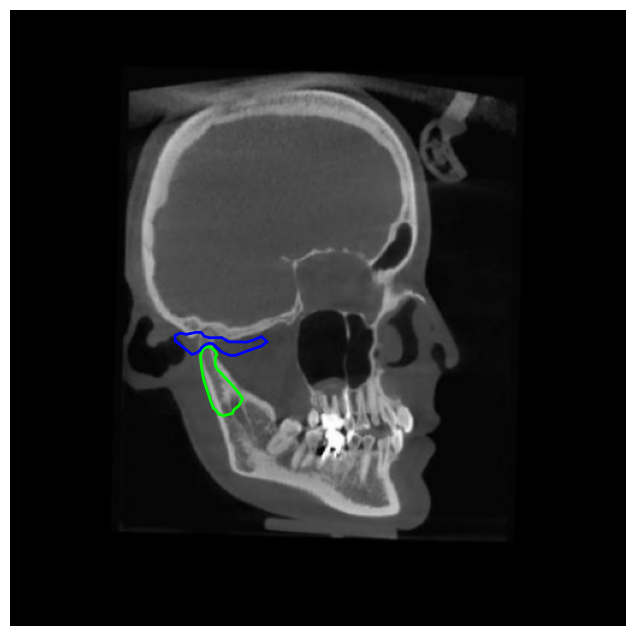

In [244]:
# Проверяем первый элемент
visualize_segmentation(dataset=dataset, index=10)

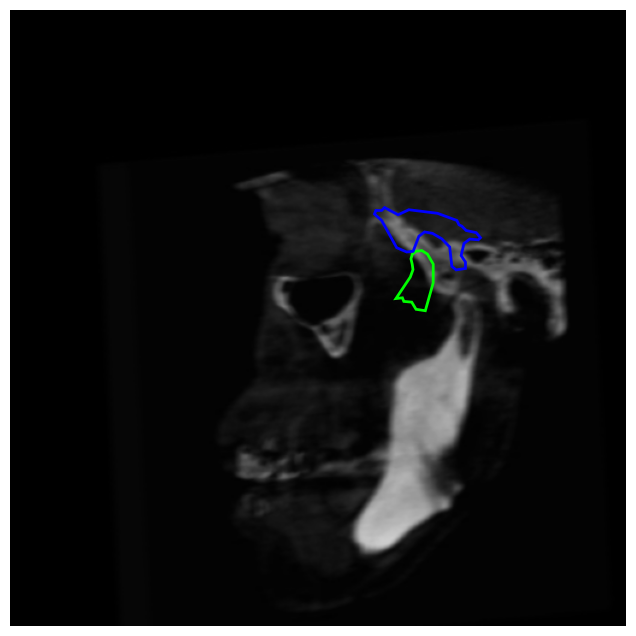

In [245]:
visualize_segmentation(dataset=dataset, index=20)


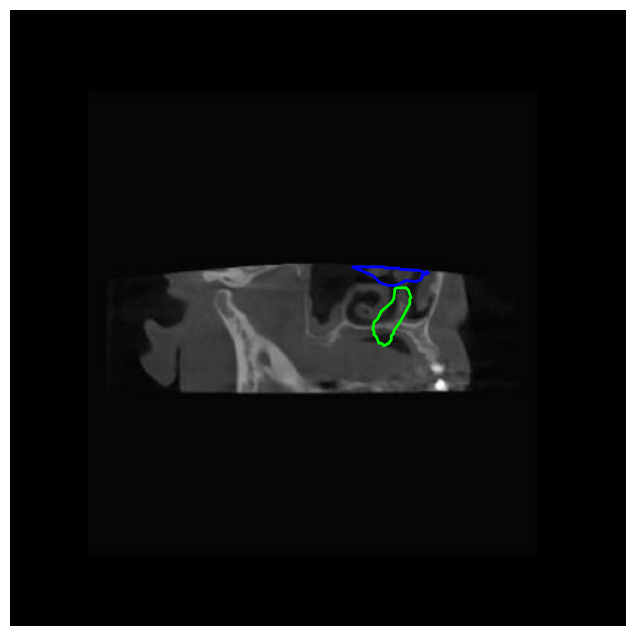

In [246]:
visualize_segmentation(dataset=dataset, index=32)
